# Detector Calibration with Volumetric Persistence - Clean Version

This is a streamlined version of the detector calibration notebook with all the working functionality preserved and unnecessary parameter optimization removed.

## Features:
- Support for multiple data formats (Excel, CSV)
- Predefined radioactive source configurations
- Simple, working volumetric persistence peak detection
- Linear calibration with cross-validation
- Comprehensive visualization and analysis tools
- Quality assessment and poor detector identification

## Workflow:
1. **Setup**: Import modules and configure data paths
2. **Data Processing**: Load spectra and detect peaks using global parameters
3. **Calibration**: Perform linear calibration across all detectors
4. **Visualization**: Generate all analysis plots
5. **Export**: Save results

## 1. Setup and Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import importlib
warnings.filterwarnings('ignore')

# Import our calibration modules
from calibration_core import (
    process_source_data,
    calibrate_detector_array,
    find_poor_detectors
)
import calibration_plots
importlib.reload(calibration_plots)  # Force reload to pick up changes
from calibration_plots import (
    plot_calibration_quality_overview,
    plot_single_detector_calibration,
    plot_combined_source_spectra,
    plot_3d_energy_spectrum,
    plot_2d_energy_heatmap
)
from source_config import (
    get_source_config,
    print_source_info,
    list_available_sources,
    GLOBAL_DETECTION_PARAMS
)

print("✅ Calibration modules loaded successfully!")
print("\n📊 Available radioactive sources:")
print_source_info()
print(f"\n🔧 Using global detection parameters with {len(GLOBAL_DETECTION_PARAMS['smoothing_range']) * len(GLOBAL_DETECTION_PARAMS['threshold_range']) * len(GLOBAL_DETECTION_PARAMS['prominence_range'])} parameter combinations")

✅ Calibration modules loaded successfully!

📊 Available radioactive sources:
  Sodium: 0.511 MeV - Na-22 - Positron emitter with 511 keV annihilation peak
  Cobalt: 1.170, 1.330 MeV - Co-60 - Two gamma rays at 1173 keV and 1332 keV
  Cesium: 0.662 MeV - Cs-137 - Single gamma ray at 662 keV
  Americium: 0.059 MeV - Am-241 - Low energy gamma ray at 59.5 keV
  Barium: 0.081, 0.356 MeV - Ba-133 - Multiple gamma rays, main peaks at 81 and 356 keV
  Europium: 0.122, 0.244, 0.344, 0.779, 0.964, 1.408 MeV - Eu-152 - Multiple gamma rays for energy calibration
  Manganese: 0.835 MeV - Mn-54 - Single gamma ray at 835 keV

🔧 Using global detection parameters with 27 parameter combinations


## 2. Configuration

Configure your calibration setup by specifying:
- Data file path and format
- Radioactive sources to use
- Sheet names (for Excel files) or file paths (for CSV files)

In [15]:
# =============================================================================
# CONFIGURATION SECTION - MODIFY THESE SETTINGS FOR YOUR DATA
# =============================================================================

# Data file configuration
DATA_FILE_PATH = "../DATI_Gullo1.xlsx/Dati_luglio.xlsx"  # Path to your data file
FILE_FORMAT = "excel"  # "excel" or "csv"

# Source configuration for Excel files (sheet mapping)
# Format: {source_name: sheet_name}
EXCEL_SHEET_MAPPING = {
    "Sodium": "Sodio I",
    "Cobalt": "Cobalto I", 
    "Cesium": "Cesio I"
}

# Source configuration for CSV files (file mapping)
# Format: {source_name: file_path}
CSV_FILE_MAPPING = {
    # "Sodium": "data/sodium_spectrum.csv",
    # "Cobalt": "data/cobalt_spectrum.csv",
    # "Cesium": "data/cesium_spectrum.csv"
}

# Settings
CALIBRATION_SETTINGS = {
    "cv_error_threshold": 0.1,  # Threshold for poor detector identification (MeV)
    "count_threshold": 100,      # Minimum count threshold for 3D plots
}

print("⚙️ Configuration loaded:")
print(f"   Data file: {DATA_FILE_PATH}")
print(f"   Format: {FILE_FORMAT}")
if FILE_FORMAT == "excel":
    print(f"   Sources: {list(EXCEL_SHEET_MAPPING.keys())}")
else:
    print(f"   Sources: {list(CSV_FILE_MAPPING.keys())}")
print(f"   CV error threshold: {CALIBRATION_SETTINGS['cv_error_threshold']} MeV")

⚙️ Configuration loaded:
   Data file: ../DATI_Gullo1.xlsx/Dati_luglio.xlsx
   Format: excel
   Sources: ['Sodium', 'Cobalt', 'Cesium']
   CV error threshold: 0.1 MeV


## 3. Data Processing

Load spectral data and detect peaks using global volumetric persistence parameters for all configured sources.

In [16]:
# Process each source and collect data
sources_data = {}
expected_energies = {}

# Determine which mapping to use based on file format
source_mapping = EXCEL_SHEET_MAPPING if FILE_FORMAT == "excel" else CSV_FILE_MAPPING

print("🔄 Processing sources...")
print("=" * 50)

for source_name in source_mapping.keys():
    print(f"\n📡 Processing {source_name}...")
    
    # Get source configuration
    source_config = get_source_config(source_name)
    expected_energies[source_name] = source_config['energies']
    
    # Add source name to config for physics-based selection
    source_config['source_name'] = source_name
    
    # Prepare source configuration for processing
    if FILE_FORMAT == "excel":
        source_config['sheet_name'] = source_mapping[source_name]
    else:
        source_config['file_path'] = source_mapping[source_name]
    
    try:
        # Process the source data using global parameters
        spectra, peaks = process_source_data(
            DATA_FILE_PATH if FILE_FORMAT == "excel" else source_mapping[source_name], 
            source_config,
            GLOBAL_DETECTION_PARAMS  # Use global parameters
        )
        
        sources_data[source_name] = {
            'spectra': spectra,
            'peaks': peaks,
            'config': source_config
        }
        
        n_channels, n_detectors = spectra.shape
        # Count total calibration peaks across detectors 
        total_peaks = 0
        for detector_data in peaks.values():
            if isinstance(detector_data, dict) and 'calibration_peaks' in detector_data:
                total_peaks += len(detector_data['calibration_peaks'])
            else:
                total_peaks += len(detector_data) if detector_data else 0
        
        print(f"   ✅ Success: {n_channels} channels, {n_detectors} detectors")
        print(f"   🎯 Total peaks detected: {total_peaks}")
        print(f"   🔍 Expected energies: {source_config['energies']} MeV")
        
    except Exception as e:
        print(f"   ❌ Error processing {source_name}: {str(e)}")
        continue

print(f"\n✅ Data processing complete!")
print(f"   Sources processed: {len(sources_data)}")
if sources_data:
    first_source = next(iter(sources_data.values()))
    n_detectors = first_source['spectra'].shape[1]
    print(f"   Total detectors: {n_detectors}")
    
    # Show parameter summary
    total_combinations = 1
    for key in ['smoothing_range', 'threshold_range', 'prominence_range']:
        if key in GLOBAL_DETECTION_PARAMS:
            total_combinations *= len(GLOBAL_DETECTION_PARAMS[key])
    print(f"   Parameter combinations tested: {total_combinations:,}")

🔄 Processing sources...

📡 Processing Sodium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 100
   🔍 Expected energies: [0.511] MeV

📡 Processing Cobalt...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 100
   🔍 Expected energies: [0.511] MeV

📡 Processing Cobalt...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 225
   🔍 Expected energies: [1.17, 1.33] MeV

📡 Processing Cesium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 225
   🔍 Expected energies: [1.17, 1.33] MeV

📡 Processing Cesium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 111
   🔍 Expected energies: [0.662] MeV

✅ Data processing complete!
   Sources processed: 3
   Total detectors: 128
   Parameter combinations tested: 27
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 111
   🔍 Expected energies: [0.662] MeV

✅ Data processing complete!
   Sources processed: 3
   Total detectors:

## 4. Detector Calibration

Perform linear calibration using detected peaks and known energies from all sources.

In [17]:
# Perform calibration across all detectors
print("🎯 Performing detector calibration...")
print("=" * 50)

try:
    calibration_results = calibrate_detector_array(sources_data, expected_energies)
    
    # Calculate calibration statistics
    successful_calibrations = 0
    cv_errors = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        if calib['slope'] is not None:
            successful_calibrations += 1
            if calib['cv_error'] is not None:
                cv_errors.append(calib['cv_error'])
    
    print(f"✅ Calibration complete!")
    print(f"   Detectors calibrated: {successful_calibrations}/{len(calibration_results)}")
    
    if cv_errors:
        mean_cv_error = np.mean(cv_errors)
        std_cv_error = np.std(cv_errors)
        print(f"   Average CV error: {mean_cv_error:.4f} ± {std_cv_error:.4f} MeV")
        print(f"   CV error range: {min(cv_errors):.4f} - {max(cv_errors):.4f} MeV")
    
    # Identify poor detectors
    poor_detectors = find_poor_detectors(
        calibration_results, 
        CALIBRATION_SETTINGS['cv_error_threshold']
    )
    
    print(f"\n🚨 Poor detectors (CV error > {CALIBRATION_SETTINGS['cv_error_threshold']} MeV):")
    if poor_detectors:
        print(f"   Detectors: {poor_detectors}")
        print(f"   Count: {len(poor_detectors)}/{len(calibration_results)} ({100*len(poor_detectors)/len(calibration_results):.1f}%)")
    else:
        print(f"   None! All detectors meet quality threshold.")
    
except Exception as e:
    print(f"❌ Calibration failed: {str(e)}")
    calibration_results = {}
    poor_detectors = []

🎯 Performing detector calibration...
✅ Calibration complete!
   Detectors calibrated: 124/128
   Average CV error: 0.3746 ± 2.6188 MeV
   CV error range: 0.0026 - 20.3154 MeV

🚨 Poor detectors (CV error > 0.1 MeV):
   Detectors: [1, 12, 16, 26, 40, 44, 47, 51, 62, 64, 70, 73, 84, 85, 86, 91, 95, 107, 123]
   Count: 19/128 (14.8%)


## 5. Calibration Quality Overview

Visualize calibration quality across all detectors with comprehensive plots.

📊 Generating calibration quality overview...


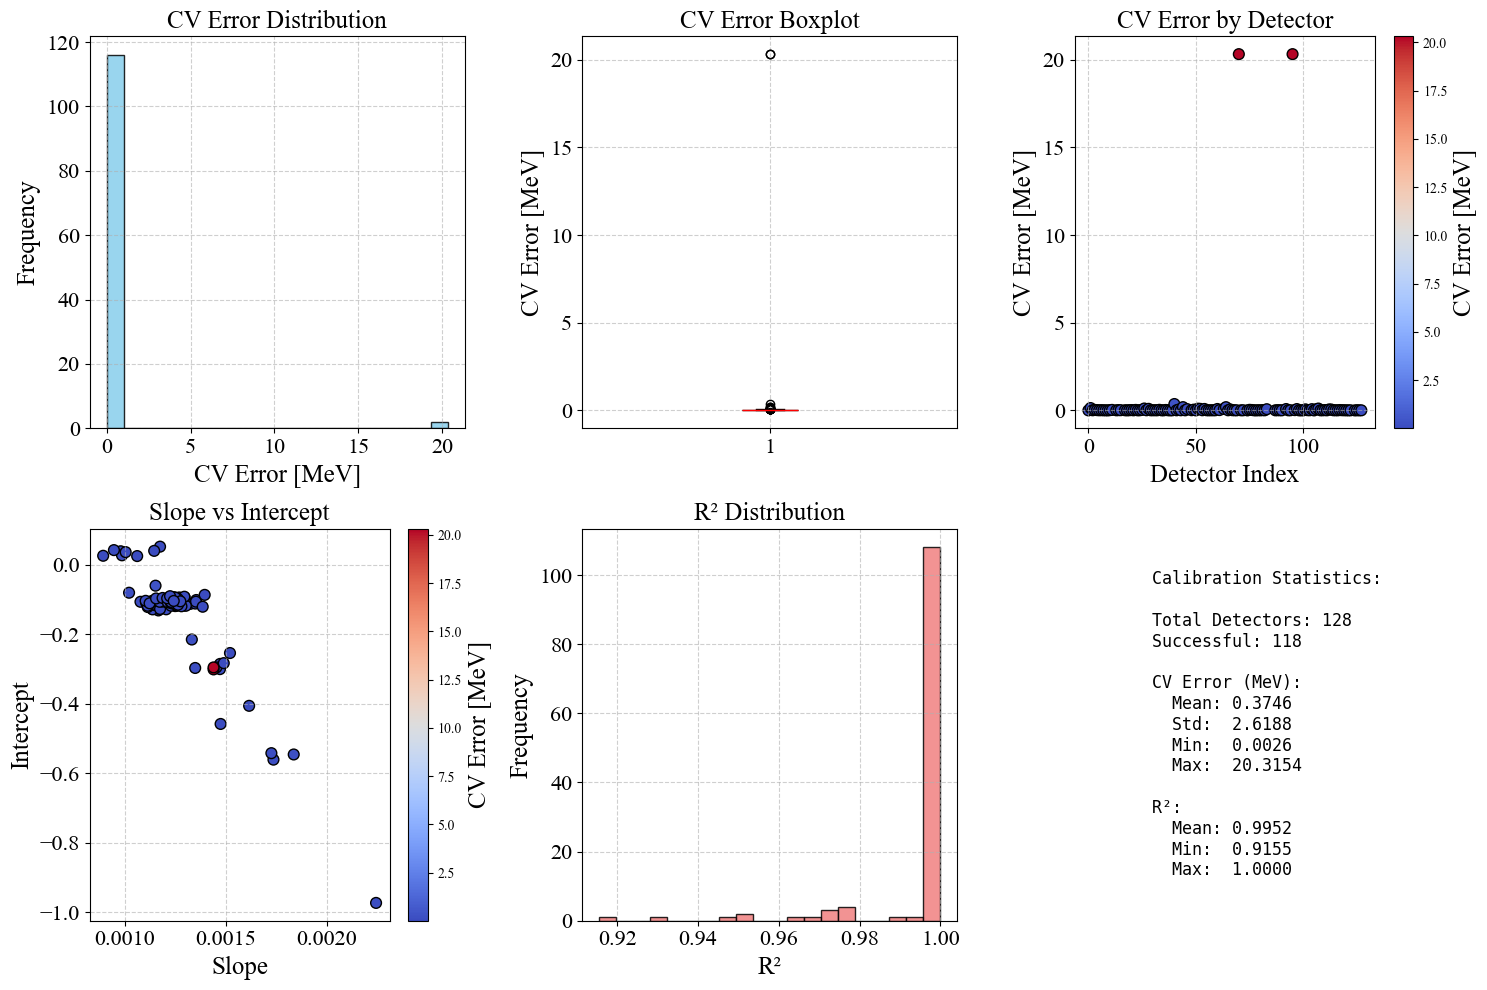

In [19]:
if calibration_results:
    print("📊 Generating calibration quality overview...")
    plot_calibration_quality_overview(calibration_results)
else:
    print("❌ No calibration results to plot.")

## 6. Individual Detector Analysis

Examine calibration details for specific detectors.

🔍 Detailed analysis of sample detectors...

🔬 Detector 0:
   Slope: 0.001142 MeV/channel
   Intercept: -0.109671 MeV
   CV Error: 0.005138 MeV
   R²: 0.999912
   Calibration points: 4


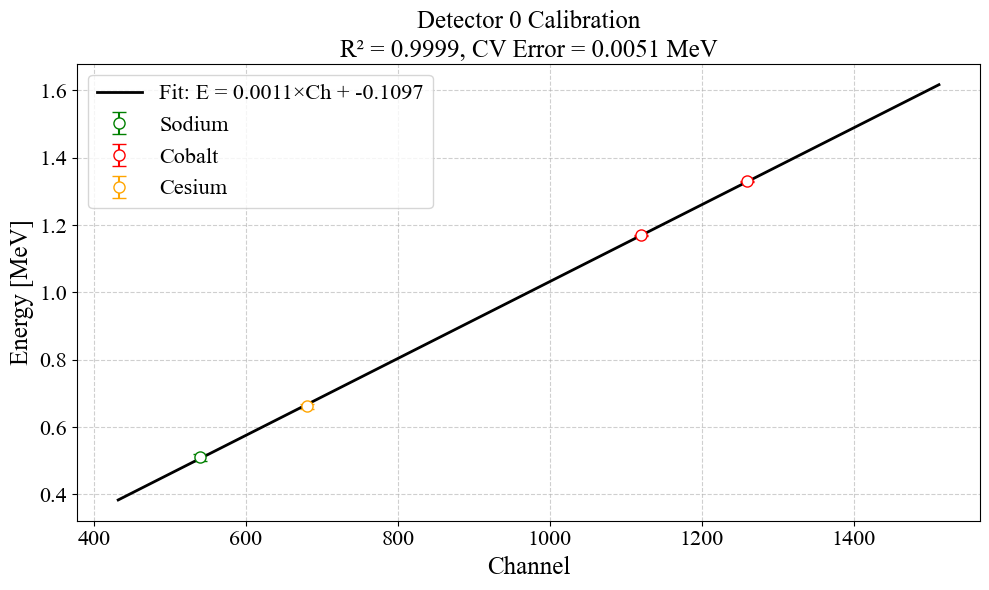


🔬 Detector 1:
   Slope: 0.001472 MeV/channel
   Intercept: -0.285346 MeV
   CV Error: 0.136952 MeV
   R²: 0.947216
   Calibration points: 4


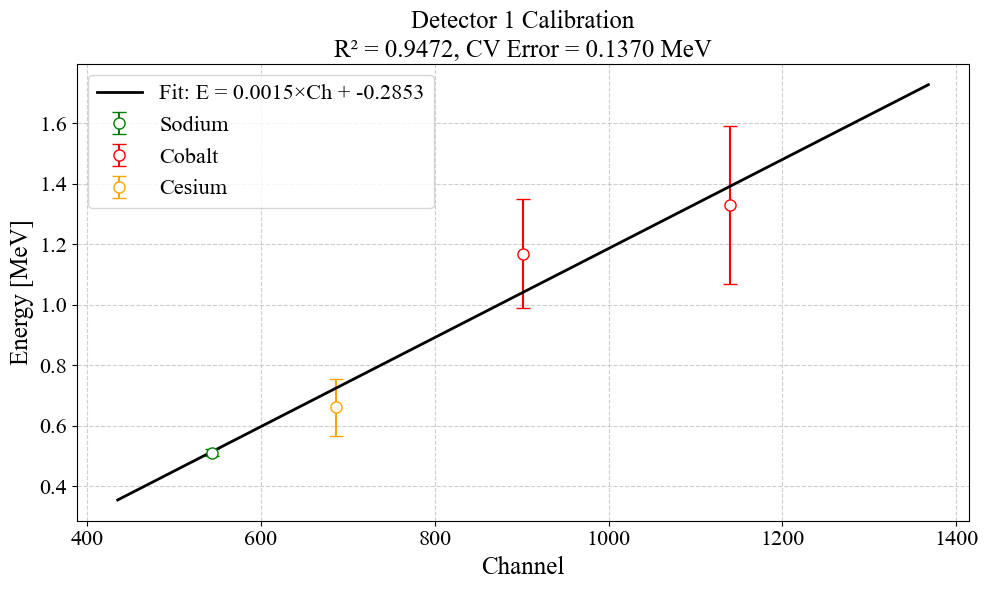


🔬 Detector 2:
   Slope: 0.001136 MeV/channel
   Intercept: -0.103907 MeV
   CV Error: 0.010701 MeV
   R²: 0.999775
   Calibration points: 4


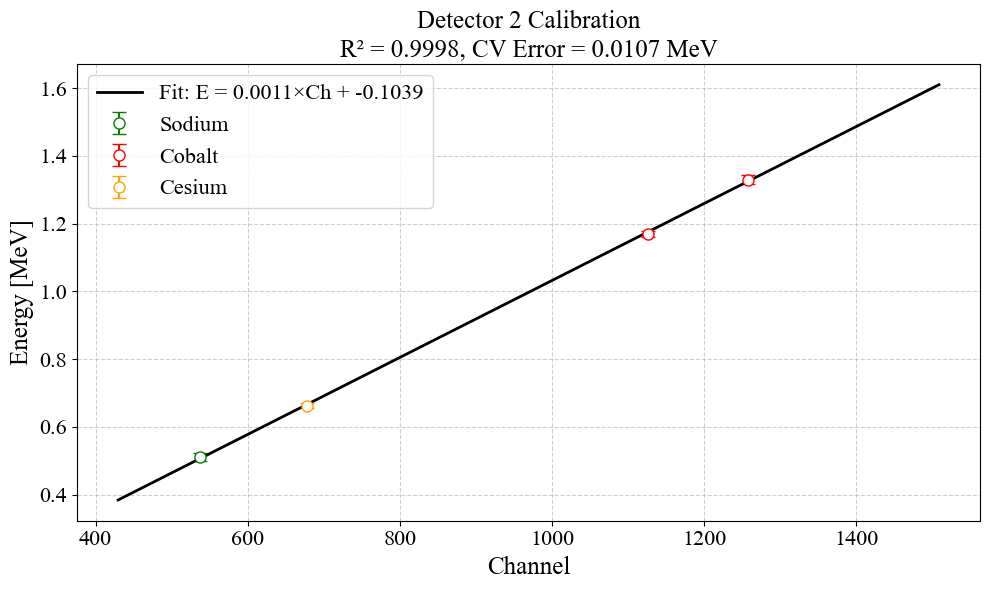

In [20]:
# Analyze a few sample detectors
sample_detectors = [0, 1, 2]  # Change these indices as needed

if calibration_results:
    print("🔍 Detailed analysis of sample detectors...")
    print("=" * 50)
    
    for detector_idx in sample_detectors:
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            print(f"\n🔬 Detector {detector_idx}:")
            if calib['slope'] is not None:
                print(f"   Slope: {calib['slope']:.6f} MeV/channel")
                print(f"   Intercept: {calib['intercept']:.6f} MeV")
                print(f"   CV Error: {calib['cv_error']:.6f} MeV")
                print(f"   R²: {calib['r_squared']:.6f}")
                print(f"   Calibration points: {calib['n_points']}")
                
                # Plot individual calibration
                plot_single_detector_calibration(detector_idx, result)
            else:
                print(f"   ❌ Calibration failed (insufficient data points)")
        else:
            print(f"\n❌ Detector {detector_idx} not found in results")
else:
    print("❌ No calibration results available for analysis.")

## 7. Source Spectrum Visualization

Visualize combined spectra from all sources for sample detectors.

📈 Combined spectra visualization for detector 0...


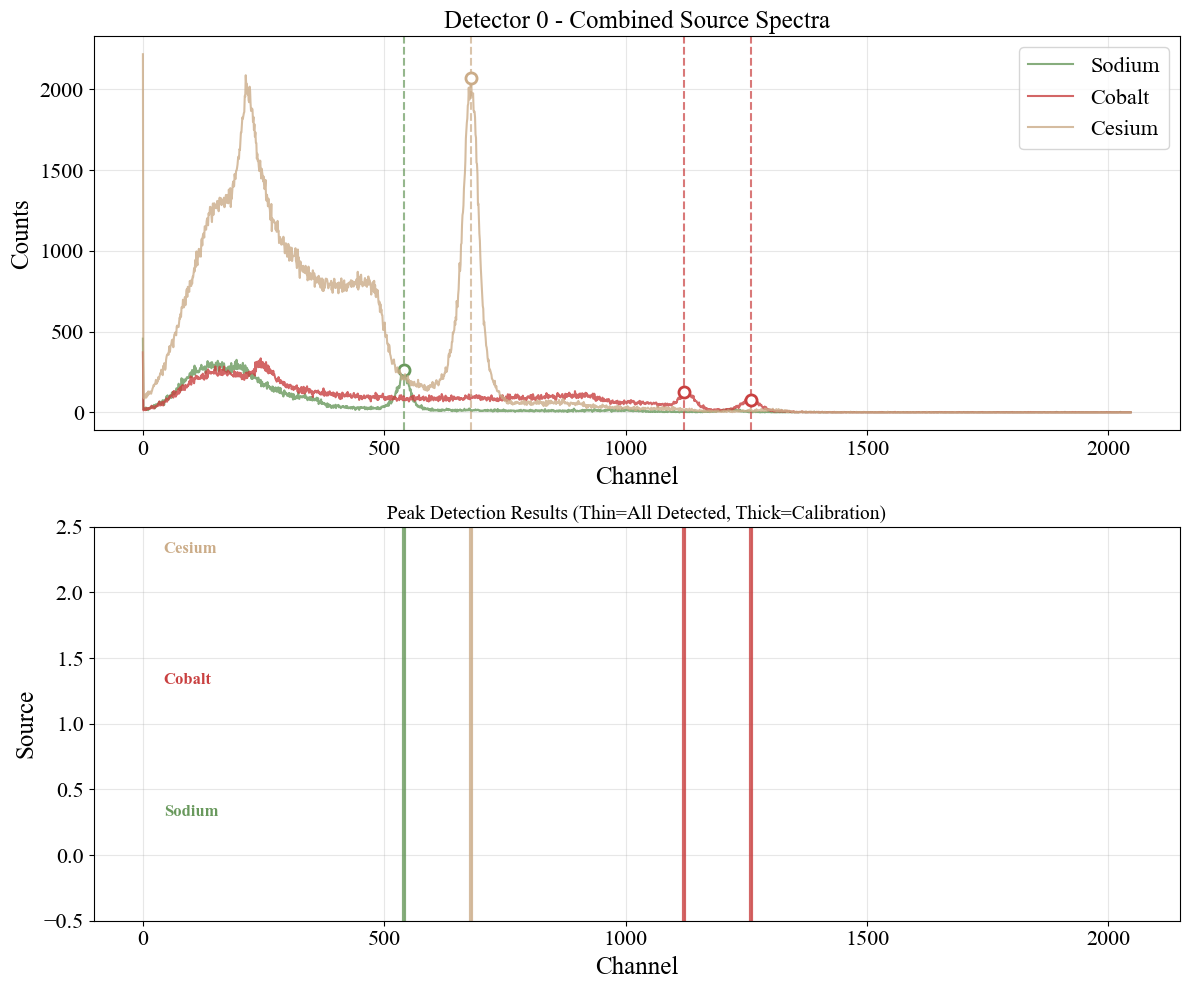

In [21]:
# Plot combined spectra for sample detectors
sample_detector_for_spectra = 0  # Change this as needed

if sources_data:
    print(f"📈 Combined spectra visualization for detector {sample_detector_for_spectra}...")
    
    # Custom colors for sources
    source_colors = {
        "Cesium": "#CBAC88", 
        "Sodium": "#69995D", 
        "Cobalt": "#C94040"
    }
    
    plot_combined_source_spectra(
        sample_detector_for_spectra, 
        sources_data, 
        source_colors
    )
else:
    print("❌ No source data available for spectrum visualization.")

## 8. 3D Energy Space Visualization

Create 3D visualization of spectra in calibrated energy space.

🌐 3D energy space visualization for Cobalt...


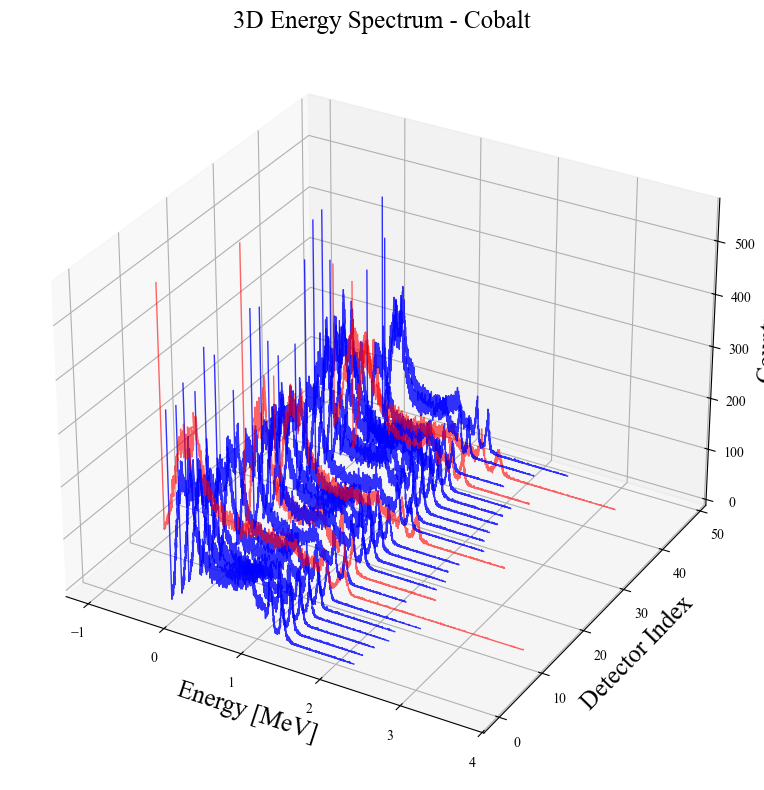

In [22]:
# 3D Energy space visualization
if sources_data and calibration_results:
    # Choose a source for visualization
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🌐 3D energy space visualization for {visualization_source}...")
        
        plot_3d_energy_spectrum(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            CALIBRATION_SETTINGS['count_threshold']
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
        print(f"   Available sources: {list(sources_data.keys())}")
else:
    print("❌ Insufficient data for 3D visualization.")

🗺️ 2D energy heatmap for Cobalt...


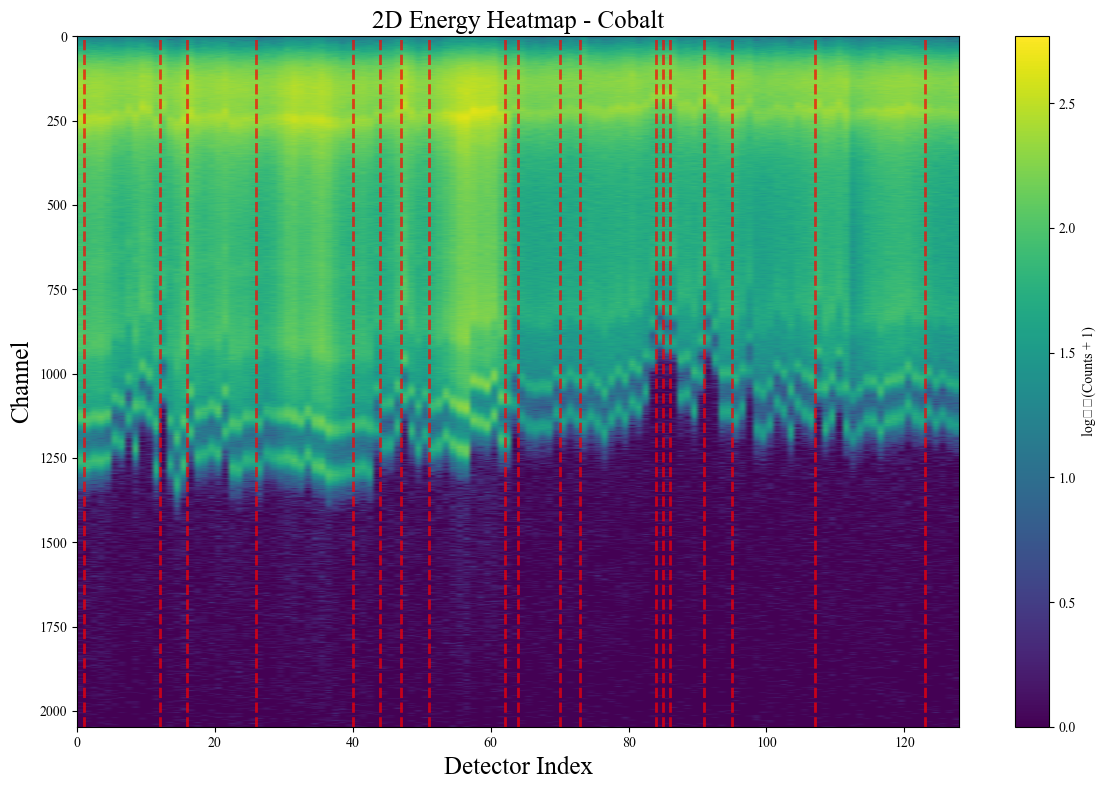

In [23]:
# 2D Energy heatmap visualization
if sources_data and calibration_results:
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🗺️ 2D energy heatmap for {visualization_source}...")
        
        plot_2d_energy_heatmap(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            CALIBRATION_SETTINGS['count_threshold']
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
else:
    print("❌ Insufficient data for 2D heatmap visualization.")

## 9. Poor Detector Investigation

Investigate detectors with poor calibration performance in detail.

🚨 Investigating 19 poor detector(s)...

🔍 Detector 1 Analysis:
   CV Error: 0.136952 MeV
   R²: 0.947216
   Data points: 4
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cobalt: 2/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


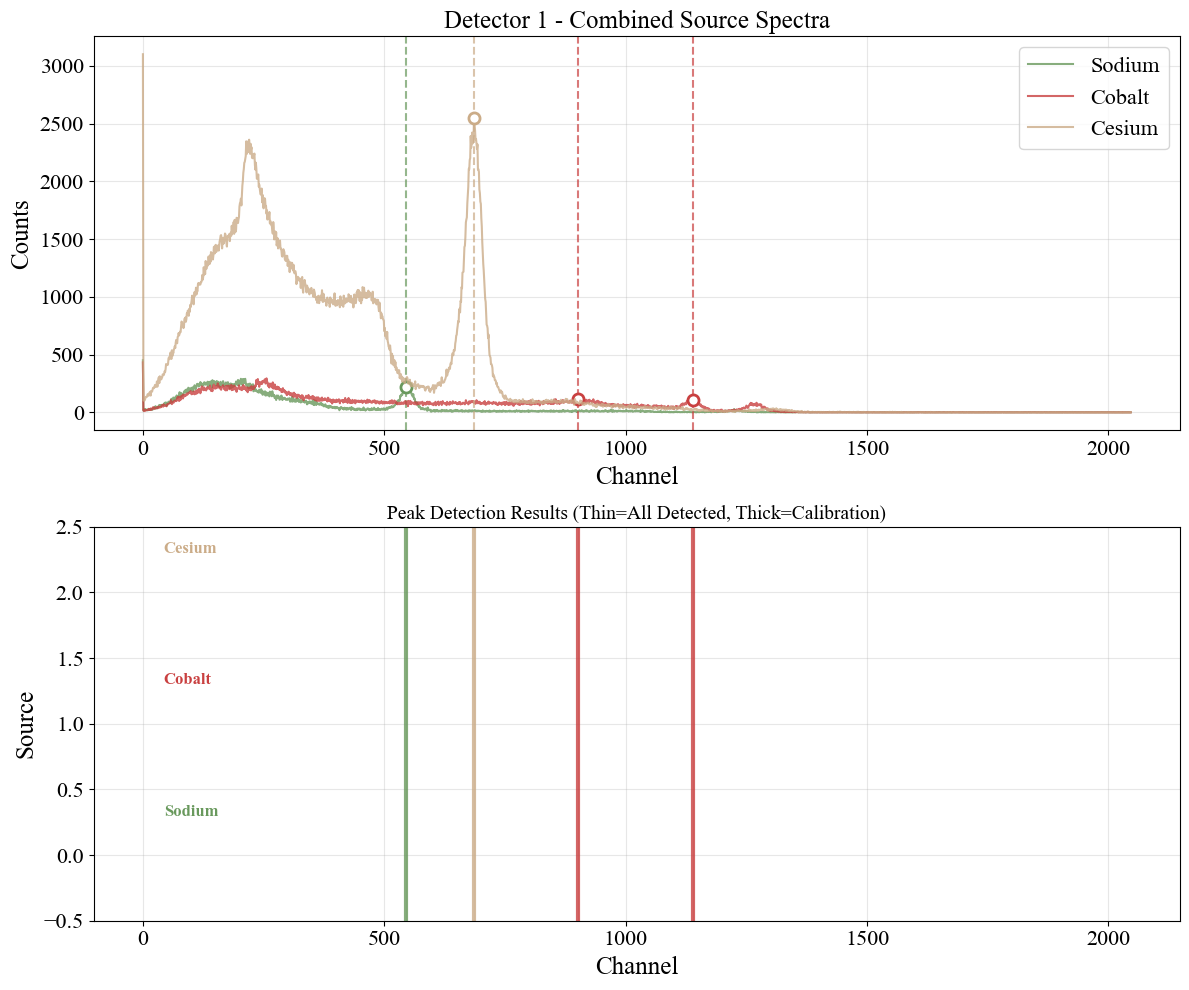

   📈 Calibration curve:


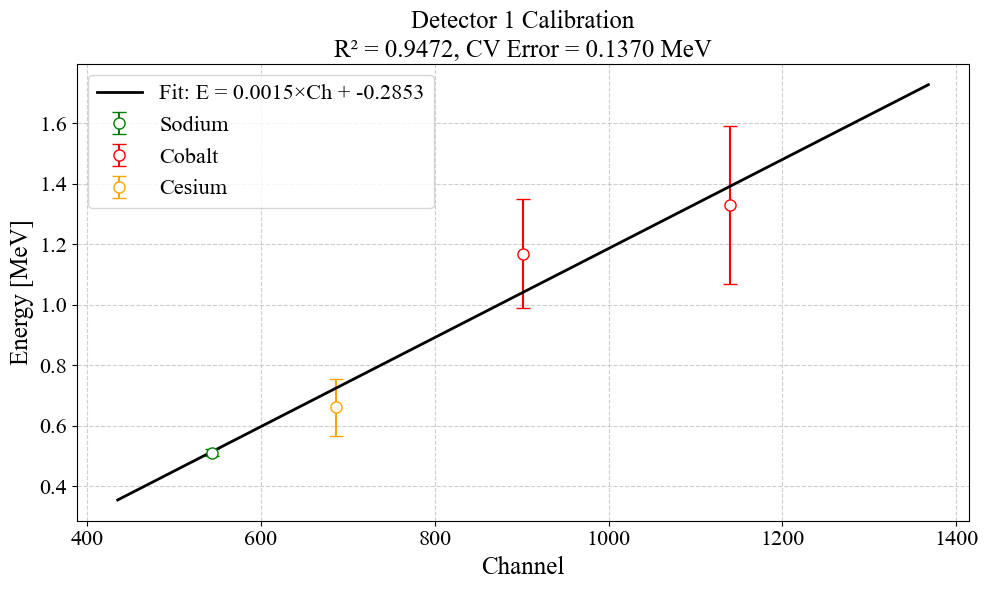


----------------------------------------

🔍 Detector 12 Analysis:
   CV Error: N/A (insufficient data)
   R²: 1.000000
   Data points: 2
   Peaks detected per source:
     Cobalt: 1/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


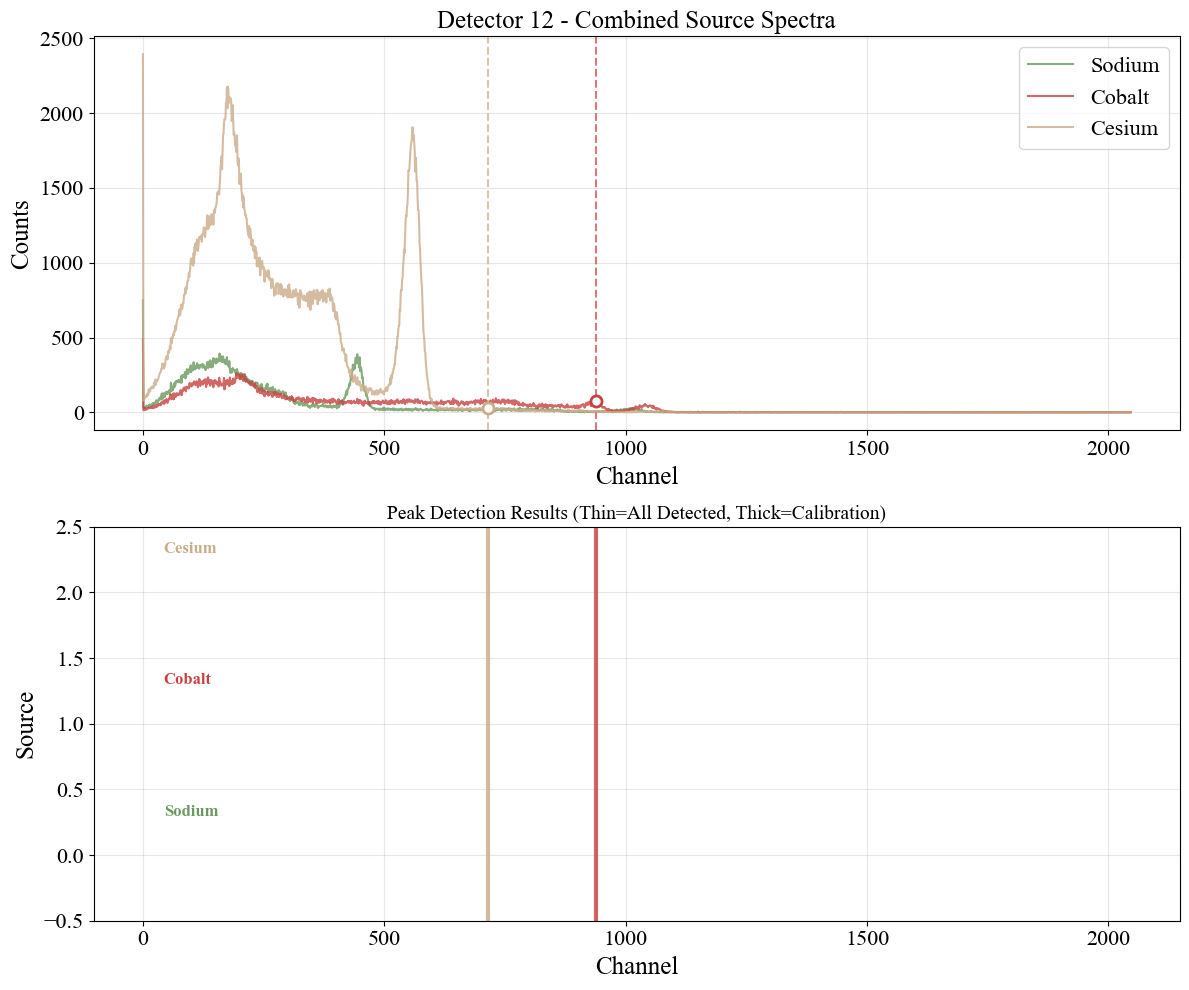

   📈 Calibration curve:


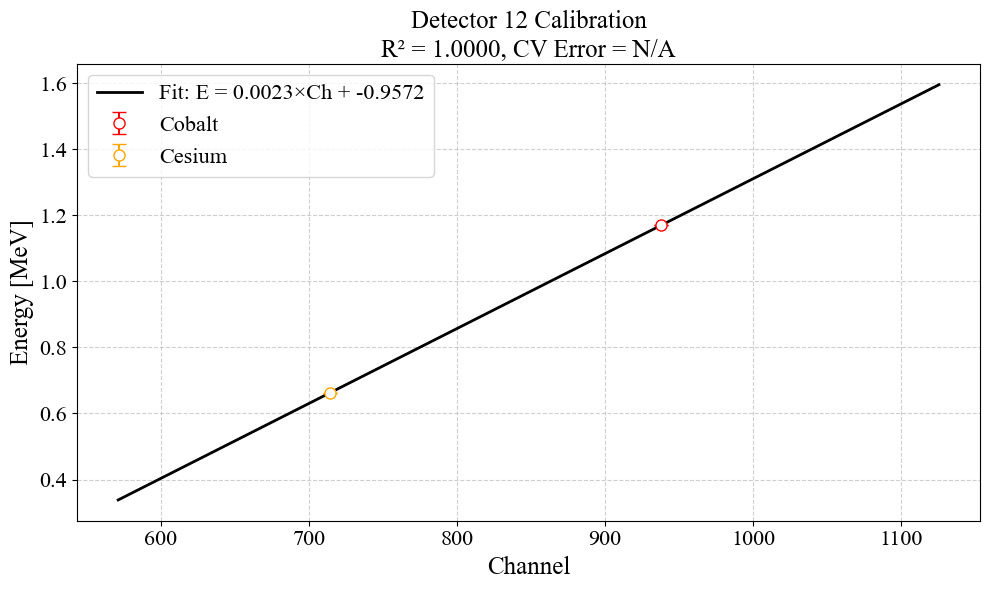


----------------------------------------

🔍 Detector 16 Analysis:
   CV Error: N/A (insufficient data)
   R²: 1.000000
   Data points: 2
   Peaks detected per source:
     Cobalt: 1/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


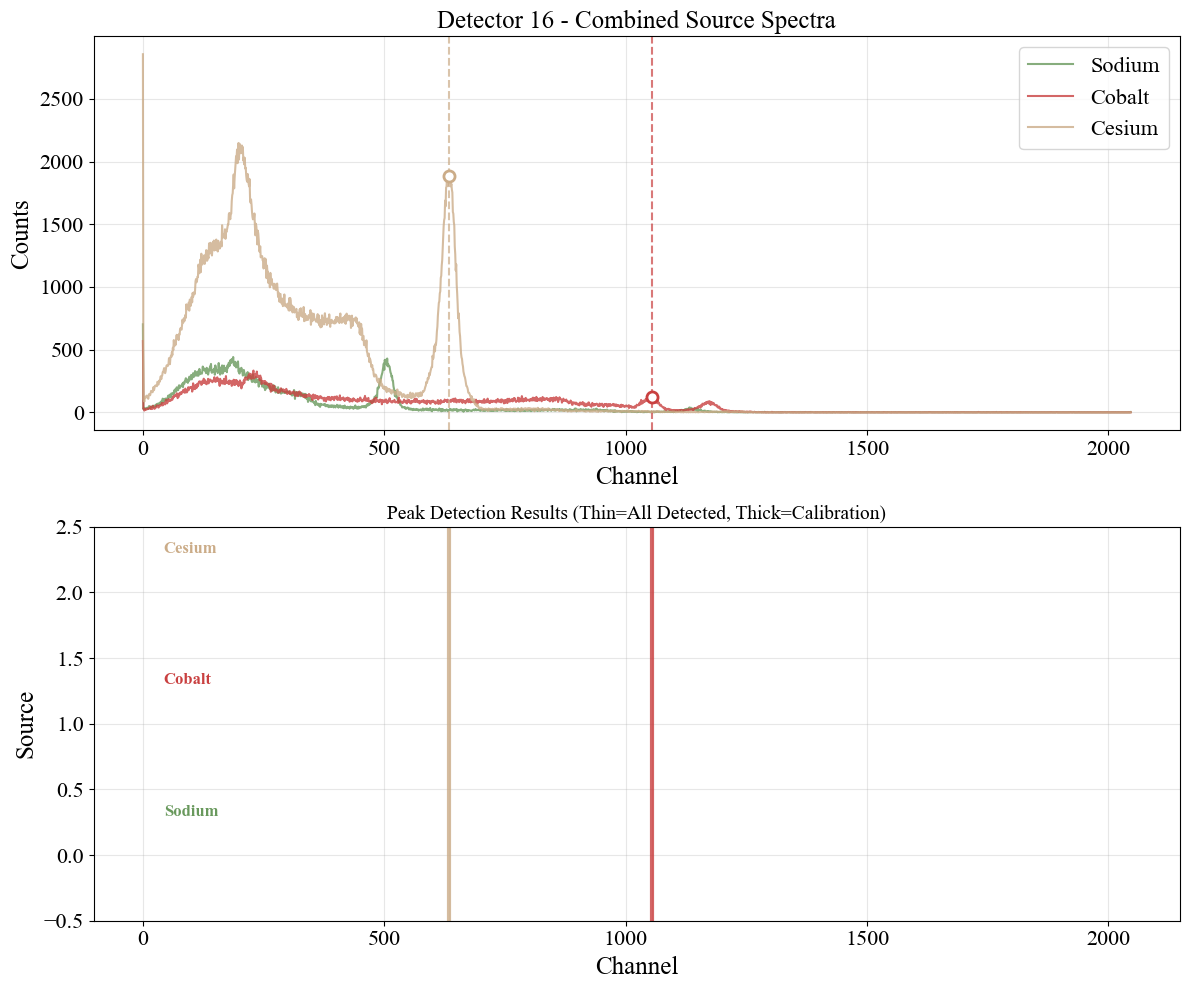

   📈 Calibration curve:


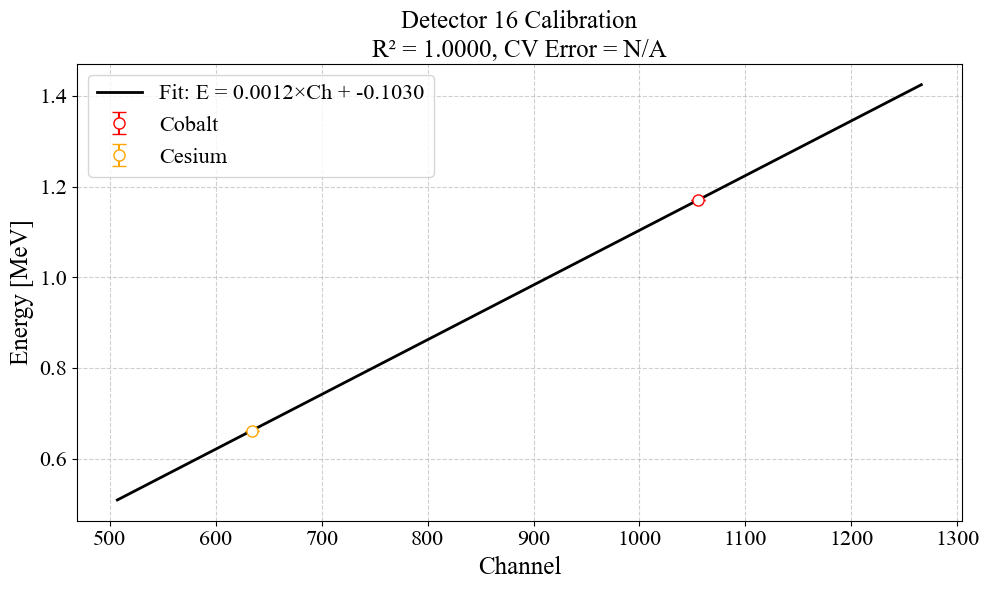


----------------------------------------


In [28]:
# Investigate poor detectors
if poor_detectors:
    print(f"🚨 Investigating {len(poor_detectors)} poor detector(s)...")
    print("=" * 60)
    
    for detector_idx in poor_detectors[:3]:  # Limit to first 3 for notebook clarity
        print(f"\n🔍 Detector {detector_idx} Analysis:")
        
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            # Handle None values safely
            cv_error = calib['cv_error']
            r_squared = calib['r_squared']
            n_points = calib['n_points']
            
            if cv_error is not None:
                print(f"   CV Error: {cv_error:.6f} MeV")
            else:
                print(f"   CV Error: N/A (insufficient data)")
                
            if r_squared is not None:
                print(f"   R²: {r_squared:.6f}")
            else:
                print(f"   R²: N/A (insufficient data)")
                
            print(f"   Data points: {n_points}")
            
            # Show peaks detected per source
            peaks_per_source = result['peaks_per_source']
            print(f"   Peaks detected per source:")
            for source, peaks in peaks_per_source.items():
                expected = len(expected_energies[source])
                detected = len(peaks)
                print(f"     {source}: {detected}/{expected} peaks")
            
            # Plot spectra for this detector
            print(f"   📊 Spectrum visualization:")
            plot_combined_source_spectra(detector_idx, sources_data)
            
            # Plot calibration if enough points
            if calib['slope'] is not None:
                print(f"   📈 Calibration curve:")
                plot_single_detector_calibration(detector_idx, result)
            else:
                print(f"   ❌ Cannot plot calibration - insufficient data points")
        
        print("\n" + "-" * 40)
else:
    print("✅ No poor detectors found - all detectors meet quality criteria!")

## 10. Export Calibration Results

Save calibration parameters and summary statistics for future use.

In [ ]:
# Export calibration results
if calibration_results:
    print("💾 Exporting calibration results...")
    
    # Create calibration summary DataFrame
    export_data = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        export_data.append({
            'detector_index': detector_idx,
            'slope_MeV_per_channel': calib['slope'],
            'intercept_MeV': calib['intercept'],
            'cv_error_MeV': calib['cv_error'],
            'r_squared': calib['r_squared'],
            'n_calibration_points': calib['n_points'],
            'p_value': calib['p_value'],
            'std_error': calib['std_err'],
            'quality_flag': 'good' if detector_idx not in poor_detectors else 'poor'
        })
    
    calibration_df = pd.DataFrame(export_data)
    
    # Save to CSV
    output_file = "detector_calibration_results.csv"
    calibration_df.to_csv(output_file, index=False)
    
    print(f"✅ Calibration results saved to: {output_file}")
    
    # Display summary statistics
    print("\n📋 Calibration Summary:")
    print("=" * 50)
    
    successful_calibrations = calibration_df['slope_MeV_per_channel'].notna().sum()
    good_detectors = (calibration_df['quality_flag'] == 'good').sum()
    
    print(f"Total detectors: {len(calibration_df)}")
    print(f"Successful calibrations: {successful_calibrations}")
    print(f"Good quality detectors: {good_detectors}")
    print(f"Poor quality detectors: {len(poor_detectors)}")
    
    if successful_calibrations > 0:
        valid_df = calibration_df.dropna(subset=['cv_error_MeV'])
        if len(valid_df) > 0:
            print(f"\nCV Error Statistics:")
            print(f"  Mean: {valid_df['cv_error_MeV'].mean():.6f} MeV")
            print(f"  Std:  {valid_df['cv_error_MeV'].std():.6f} MeV")
            print(f"  Min:  {valid_df['cv_error_MeV'].min():.6f} MeV")
            print(f"  Max:  {valid_df['cv_error_MeV'].max():.6f} MeV")
        
        valid_r2 = calibration_df.dropna(subset=['r_squared'])
        if len(valid_r2) > 0:
            print(f"\nR² Statistics:")
            print(f"  Mean: {valid_r2['r_squared'].mean():.6f}")
            print(f"  Min:  {valid_r2['r_squared'].min():.6f}")
            print(f"  Max:  {valid_r2['r_squared'].max():.6f}")
    
    # Display first few rows
    print(f"\n🔢 Sample calibration data:")
    display(calibration_df.head(10))
    
else:
    print("❌ No calibration results to export.")

## 11. Summary

Final summary of the calibration process and recommendations.

In [ ]:
print("📊 CALIBRATION SUMMARY")
print("=" * 60)

if sources_data:
    print(f"\n✅ Sources processed: {len(sources_data)}")
    for source_name, data in sources_data.items():
        n_channels, n_detectors = data['spectra'].shape
        print(f"   {source_name}: {n_channels} channels, {n_detectors} detectors")
    
    if calibration_results:
        successful = sum(1 for r in calibration_results.values() 
                        if r['calibration']['slope'] is not None)
        print(f"\n🎯 Calibration success rate: {successful}/{len(calibration_results)} "
              f"({100*successful/len(calibration_results):.1f}%)")
        
        if poor_detectors:
            print(f"\n⚠️  Poor detectors: {len(poor_detectors)} "
                  f"({100*len(poor_detectors)/len(calibration_results):.1f}%)")
            print(f"   Detector indices: {poor_detectors[:10]}")  # Show first 10
            if len(poor_detectors) > 10:
                print(f"   ... and {len(poor_detectors)-10} more")
        else:
            print(f"\n✅ All detectors meet quality threshold!")
        
        print(f"\n📁 Output files generated:")
        print(f"   📄 detector_calibration_results.csv")
        print(f"   📊 Various calibration plots (displayed above)")
        
        print(f"\n🔍 Recommendations:")
        if poor_detectors:
            print(f"   🔧 Investigate poor detectors for hardware issues")
            print(f"   📊 Consider excluding poor detectors from analysis")
        
        cv_errors = [r['calibration']['cv_error'] for r in calibration_results.values()
                    if r['calibration']['cv_error'] is not None]
        if cv_errors:
            mean_error = np.mean(cv_errors)
            if mean_error > 0.02:
                print(f"   📈 Consider using more calibration sources for better accuracy")
            if mean_error < 0.01:
                print(f"   ✨ Excellent calibration accuracy achieved!")
        
        print(f"\n🚀 Next steps:")
        print(f"   📊 Use calibration parameters for energy analysis")
        print(f"   🔄 Repeat calibration periodically to check stability")
        print(f"   📋 Document calibration procedure and results")
    else:
        print(f"\n❌ Calibration failed - check data and parameters")
else:
    print(f"\n❌ No data processed - check file paths and configuration")

print(f"\n" + "=" * 60)
print(f"🎉 Calibration analysis complete!")